<a href="https://colab.research.google.com/github/easajtar20/Classification-of-Long-Distance-Longboarding/blob/main/longboard_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = "/content/drive/MyDrive/Longboard Project/Accelerometer Data/" # change path to the drive folder with all the data 

Mounted at /content/drive


# Imports


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
import timeit

import matplotlib.pyplot as plt
import pywt
import scipy.stats
import json

import datetime as dt

from scipy.fft import rfft, rfftfreq
from collections import defaultdict, Counter
from google.colab import files

from matplotlib.colors import ListedColormap
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import datasets


dict_classifiers = {
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear SVM": SVC(),
    "Neural Net": MLPClassifier(alpha = 1),
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Process": GaussianProcessClassifier()
}

p = './graphs'

# check whether directory already exists
if not os.path.exists(p):
  os.mkdir(p)
  print("Folder %s created!" % p)
else:
  print("Folder %s already exists" % p)
  

Folder ./graphs already exists


In [ ]:
plt.rcParams["figure.figsize"] = [25.00, 24.0]
plt.rcParams["figure.autolayout"] = True

# Main method

In [ ]:
def main():
  hParams = {
    "datasetProportion": 1.0,
    "numEpochs": 50,
    "denseLayers": [14, 20, 10, 4, 1],
    "valProportion": 0.1,
    "experimentName": "ML_results",
    "waveletName": 	"rbio3.1"
  }

  x_train, y_train = getFeaturesTrainData()
  # x_pred = getFeaturesPredData()
  x_test, y_test = x_train[:int(0.2 * x_train.shape[0])], y_train[:int(0.2 * y_train.shape[0])]

  print(x_train.shape, y_train.shape)
  print(x_test.shape, y_test.shape)

  # x_train = feature_extraction(x_train, hParams['waveletName'])
  # x_test = feature_extraction(x_test, hParams['waveletName'])
  # x_pred = feature_extraction(x_pred, hParams['waveletName'])

  dataSubsets = (x_train, y_train, x_test, y_test)
  trainResults = batch_classify(dataSubsets)
  # writeExperimentalResults(hParams, trainResults)
  display_dict_models(trainResults)

In [ ]:
# Write an algorithm to split training data into chunks of uniform amount of time (2 seconds)

# have lots of evidence to back up claims (graphs of fft, graphs of displacement integration), know your audience, know your purpose, be

# Feature extraction (24)

In [ ]:
def getFeatures(dict, time):
	features = []

	# y dimension -> acceleration, x, z dimensions -> position displacements
	a = np.array(dict["ay"])
	x1 = np.array(dict["xx"])
	x2 = np.array(dict["xz"])

	# Basically get the fourier transform plot of the position displacement data
	newthing1 = np.array([x - x1.mean() for x in x1])
	newthing2 = np.array([x - x2.mean() for x in x2])

	yf1 = np.abs(rfft(newthing1))
	yf2 = np.abs(rfft(newthing2))

	xf1 = rfftfreq(len(x1), 1 / len(x1))
	xf2 = rfftfreq(len(x2), 1 / len(x2))

	plt.plot(xf1[:15], yf1[:15])
	plt.savefig("graphs/fourier")

	# Get the most dominant frequency (singular) of a fourier transform
	peak1 = yf1.max()
	peak2 = yf2.max()

	# add them
	freq1 = 0
	freq2 = 0

	for i in range(len(xf1)):
		if yf1[i] == peak1:
			freq1 = xf1[i]

	for i in range(len(xf2)):
		if yf2[i] == peak2:
			freq2 = xf2[i]

	# Get a bunch of statistical features (all mentioned in the paper), some of them aren't necessary but included for experimental purpose
	n51 = np.nanpercentile(x1, 5)
	n251 = np.nanpercentile(x1, 25)
	n751 = np.nanpercentile(x1, 75)
	n951 = np.nanpercentile(x1, 95)
	median1 = np.nanpercentile(x1, 50)
	mean1 = np.nanmean(x1)
	std1 = np.nanstd(x1)
	var1 = np.nanvar(x1)
	rms1 = np.nanmean(np.sqrt(x1**2))

	n52 = np.nanpercentile(x2, 5)
	n252 = np.nanpercentile(x2, 25)
	n752 = np.nanpercentile(x2, 75)
	n952 = np.nanpercentile(x2, 95)
	median2 = np.nanpercentile(x2, 50)
	mean2 = np.nanmean(x2)
	std2 = np.nanstd(x2)
	var2 = np.nanvar(x2)
	rms2 = np.nanmean(np.sqrt(x2**2))

	features.append(freq1 + freq2)
	features.append(x1.max())
	features.append(x1.min())
	features.append(x2.max())
	features.append(x2.min())

	features.append(n51)
	features.append(n251)
	features.append(n751)
	features.append(n951)
	features.append(median1)
	features.append(mean1)
	features.append(std1)
	features.append(var1)
	features.append(rms1)

	features.append(n52)
	features.append(n252)
	features.append(n752)
	features.append(n952)
	features.append(median2)
	features.append(mean2)
	features.append(std2)
	features.append(var2)
	features.append(rms2)
	
	# This is the difference between the maximum and minimum accelerations in the y dimension
	features.append(a.max()-a.min())
 
	return features

# Get the times where a full period is completed and get the peaks of the wave data

In [ ]:
# get a period, which means when it changes direction twice
def getTimes(y, timeData):
	times = []
	record = 0
	index = 1

	# Get peak (where data is both higher or both lower than the 2 points adjacent to it)
	for i in range(1, len(y) - 1):
		if (y[i - 1] < y[i] and y[i + 1] < y[i]) or (y[i - 1] > y[i] and y[i + 1] > y[i]):
			if index % 2 != 0:
				times.append(timeData[i] - record)	
			else:
				record = timeData[i]

			index += 1

	return times

# Normalize data (Z-score and rotation)

In [ ]:
# what if the dimensions are divided into 2 parts, one part contains 2 dimensions and the other 1, the part where the derivative is lowest is deemed to be the dimension of movement, and the other 2 are the dimensions of wave oscillation
# different data normalization methods were tested, below is the z-score normalization method (you can look it up, but it basically makes data easier to process)
def normalized_data(fileName):
	columns = ["az", "ay", "ax", "time", "Azimuth", "Pitch", "Roll"]

	df = pd.read_csv(fileName, usecols=columns)

	# Get mean & standard deviation of raw acceleration data
	meanx, stdx = df.ax.mean(), df.ax.std()
	meany, stdy = df.ay.mean(), df.ay.std()
	meanz, stdz = df.az.mean(), df.az.std()

	# Get max & min of raw acceleration data
	maxx, minx = df.ax.max(), df.ax.min()
	maxy, miny = df.ay.max(), df.ay.min()	
	maxz, minz = df.az.max(), df.az.min()

	# Do the calculating
	for i in range(len(df)):
		df.ax[i] = (df.ax[i] - minx) / (maxx - minx)
		df.ay[i] = (df.ay[i] - miny) / (maxy - miny)
		df.az[i] = (df.az[i] - minz) / (maxz - minz)

	return df

# input: arrays of displacement vectors in 3 dimensions after 2 seconds
# get angle of the vector from each dimension, trigonometry
def normalize_vector(xx, xy, xz):
	lx, ly, lz = xx[-1] - xx[0], xy[-1] - xy[0], xz[-1] - xz[0]
	hypo = (lx ** 2 + ly ** 2 + lz ** 2) ** 0.5 
	side1 = (lx ** 2 + ly ** 2) ** 0.5
	side2 = ly
	newRoll = np.arccos(side1 / hypo)
	newAzimuth = np.arccos(side2 / hypo)

	return newRoll, newAzimuth

# Get feature windows

In [ ]:
# get the features (12 features) for each window of half a period, including the one dominant frequency in that time period and the time of the window, since the larger the window the more it means that it is not a pumping period
def getFeaWindow(dataset):
	features = []
	cur = 0
	j = 0
	# Create a dictionary of all the different data within 1 time window (period window)
	dict = {"xx": [], "xy": [], "xz": [], "az": [], "ax": [], "ay": [], "Azimuth": [], "Pitch": [], "Roll": []}
	times = getTimes(dataset['x(t)(z)'], dataset['time'])
	for i in range(len(dataset)):
		# windowx.append(dataset.iloc[i]['x(t)(x)'])
		# windowy.append(dataset.iloc[i]['x(t)(y)'])
		# windowz.append(dataset.iloc[i]['x(t)(z)'])

		# Get data from csv
		xz = dataset.iloc[i]['x(t)(z)raw']
		xx = dataset.iloc[i]['x(t)(x)raw']
		xy = dataset.iloc[i]['x(t)(y)raw']
		az = dataset.iloc[i]['az']
		ax = dataset.iloc[i]['ax']
		ay = dataset.iloc[i]['ay']
		Azimuth = dataset.iloc[i]['Azimuth']
		Pitch = dataset.iloc[i]['Pitch']
		Roll = dataset.iloc[i]['Roll']

		# Insert to dict
		dict['xx'].append(xx)
		dict['xy'].append(xy)
		dict['xz'].append(xz)
		dict['ax'].append(ax)
		dict['ay'].append(ay)
		dict['az'].append(az)
		dict['Azimuth'].append(Azimuth)
		dict['Pitch'].append(Pitch)
		dict['Roll'].append(Roll)

		# segmentation + processing + feature extraction ****
		if j < len(times) and i < len(dataset) and dataset.iloc[i].time >= (times[j] + cur): # -> it should be the sum so far
			# freqx, freqy, freqz = fft(np.array(freqx)), fft(np.array(freqy)), fft(np.array(freqz))
			newRoll, newAzimuth = normalize_vector(dict['xx'], dict['xy'], dict['xz'])
			# xangss += xangs 
			# yangss += yangs 
			# zangss += zangs
			for i in range(len(dict['xx'])):
				matrix = (dict['xx'][i], dict['xy'][i], dict['xz'][i])
				last = rotation(matrix, newAzimuth, 0, newRoll)
				dict['xx'][i] = last[0]
				dict['xy'][i] = last[1]
				dict['xz'][i] = last[2]
 
			feature = getFeatures(dict, times[j])
			if not np.nan in feature:
				features.append(feature)
			# windowx, windowy, windowz = [], [], []
			dict = {"xx": [], "xy": [], "xz": [], "az": [], "ax": [], "ay": [], "Azimuth": [], "Pitch": [], "Roll": []}
			cur += times[j]
			j += 1

	print("shape of the features array is", np.array(features).shape)

	return np.array(features)

# Methods that apply rotation matrix and Verlet integration 

In [ ]:
# Method to rotate a matrix 
def rotation(matrix, alpha, beta, theta):
	alpha, beta, theta = -alpha * np.pi / 180, -beta * np.pi / 180, -theta * np.pi / 180
	rotation_matrix = [[np.cos(alpha) * np.cos(beta), np.cos(alpha) * np.sin(beta) * np.sin(theta) - np.sin(alpha) * np.cos(theta), np.cos(alpha) * np.sin(beta) * np.cos(theta) + np.sin(alpha) * np.sin(theta)]
	                 ,[np.sin(alpha) * np.cos(beta), np.sin(alpha) * np.sin(beta) * np.sin(theta) + np.cos(alpha) * np.cos(theta), np.sin(alpha) * np.sin(beta) * np.sin(theta) - np.cos(alpha) * np.sin(theta)]
	                 ,[-np.sin(beta), np.cos(beta) * np.sin(theta), np.cos(beta) * np.cos(theta)]]


	return np.matmul(matrix, rotation_matrix) 

# Method to Verlet integrate the raw acceleration data
def transformation(df):

	transformed_acceleration = []

	for index in range(len(df)):
		alpha, beta, theta = df['Azimuth'].iat[index], df['Pitch'].iat[index], df['Roll'].iat[index]
		acceleration_matrix = [df['ax'].iat[index], df['ay'].iat[index], df['az'].iat[index]]
		transformed_acceleration.append(rotation(acceleration_matrix, alpha, beta, theta))

	df['transformed_ax'] = [x[0] for x in transformed_acceleration]
	df['transformed_ay'] = [x[1] for x in transformed_acceleration]
	df['transformed_az'] = [x[2] for x in transformed_acceleration]

	delta_v, xtraw, delta_t, prev_pos, pos = 0, [[0, 0, 0]], 0, [0] * 3, [0] * 3

	for i in range(len(df) - 1):
		delta_t = df.iloc[i + 1]['time'] - df.iloc[i]['time']
		delta_v = [delta_t * df.iloc[i]['ax'], delta_t * df.iloc[i]['ay'], delta_t * df.iloc[i]['az']]
		pos = [x + y for (x, y) in zip([2 * y - z for (y, z) in zip(pos, prev_pos)], [delta_t * delta_v[0], delta_t * delta_v[1], delta_t * delta_v[2]])]
		prev_pos = pos
		xtraw.append(pos)

	df['x(t)(x)raw'] = [x[0] for x in xtraw] 
	df['x(t)(y)raw'] = [x[1] for x in xtraw]
	df['x(t)(z)raw'] = [x[2] for x in xtraw]

	delta_v, xt, delta_t, prev_pos, pos = 0, [[0, 0, 0]], 0, [0] * 3, [0] * 3

	for i in range(len(df) - 1):
		delta_t = df.iloc[i + 1]['time'] - df.iloc[i]['time']
		delta_v = [delta_t * df.iloc[i]['transformed_ax'], delta_t * df.iloc[i]['transformed_ay'], delta_t * df.iloc[i]['transformed_az']]
		pos = [x + y for (x, y) in zip([2 * y - z for (y, z) in zip(pos, prev_pos)], [delta_t * delta_v[0], delta_t * delta_v[1], delta_t * delta_v[2]])]
		prev_pos = pos
		xt.append(pos)

	df['x(t)(x)'] = [x[0] for x in xt] 
	df['x(t)(y)'] = [x[1] for x in xt]
	df['x(t)(z)'] = [x[2] for x in xt]

	return df

# Methods to plot

In [ ]:
# Plot a table of all the training/test results using the classifiers
def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

# A bunch of methods to write, read training/testing results (accuracy, loss) and predictions to txt files 
def writeExperimentalResults(hParams, trainResults, testResults, predictions):
	f = open("results/models/" + hParams["resultsName"] + "_LSTM" + ".txt", 'w')
	f.write(str(hParams) + '\n\n')
	f.write(str(trainResults) + '\n\n')
	f.write(str(testResults) + '\n\n')

	f1 = open("results/models/" + hParams["predictName"] + "_LSTM" + ".txt", 'w')
	f1.write(str(hParams) + '\n\n')
	f1.write(str(predictions))

	percentReport = prediction_result(predictions)
	writePercentReport(hParams, percentReport)

	f.close()
	f1.close()

def writePercentReport(hParams, percentReport):
	ff = open("results/models/" + hParams["percentName"] + "_LSTM" + ".txt", 'w')
	ff.write(percentReport)
	ff.close()

def writePredictions(hParams, predictions):
	ff = open("results/models/" + hParams["predictName"] + "_LSTM" + ".txt", 'w')
	ff.write(str(predictions))
	ff.close()

def readExperimentalResults(fileName):
	f = open("results/models/" + fileName + ".txt",'r')
	data = f.read().split('\n\n')

	data[0] = data[0].replace("\'", "\"")
	data[1] = data[1].replace("\'", "\"")

	hParams = json.loads(data[0])
	trainResults = json.loads(data[1])
	testResults = json.loads(data[2])

	return hParams, trainResults, testResults

def readPredResults(fileName):
	f = open("results/models/" + fileName + ".txt", "r")
	data = f.read().split('\n\n')

	data[0] = data[0].replace("\'", "\"")
	data[1] = data[1].replace("\'", "\"")

	hParams = json.loads(data[0])
	predictions = json.loads(data[1])
	return hParams, predictions

def plotPredictions(predictions, title):
	plotCurves(x=np.array([x for x in range(len(predictios))]), 
				yList= predictions, 
				xLabel="time (t)", 
				yLabelList=itemsToPlot, 
				title= title + "predictions")

# Plot curves using matplot
def plotCurves(x, yList, xLabel="", yLabelList=[], title=""):
	fig, ax = plt.subplots()
	y = np.array(yList).transpose()
	ax.plot(x, y)
	ax.set(xlabel=xLabel, title=title)
	plt.legend(yLabelList, loc='best', shadow=True)
	ax.grid()
	yLabelStr = "__" + "__".join([label for label in yLabelList])
	filepath = "results/models/" + title + " " + yLabelStr + ".png"
	fig.savefig(filepath)
	print("Figure saved in", filepath)

def plotPoints(xList, yList, pointLabels=[], xLabel="", yLabel="", title="", filename="pointPlot"):
	plt.figure()
	plt.scatter(xList,yList)
	plt.xlabel(xLabel)
	plt.ylabel(yLabel)
	plt.title(title)
	if pointLabels != []:
		for i, label in enumerate(pointLabels):
			plt.annotate(label, (xList[i], yList[i]))
	filepath = "results/" + filename + ".png"
	plt.savefig(filepath)
	print("Figure saved in", filepath)

# def processResults():
# 	hParams, trainResults, testResults = readExperimentalResults("freq_test_results")
# 	hParams, dPredictions = readPredResults("freq_predictions")

# 	itemsToPlot = ['accuracy', 'val_accuracy']
# 	plotCurves(x=np.arange(0, hParams['numEpochs']), 
# 				yList=[trainResults[item] for item in itemsToPlot], 
# 				xLabel="Epoch",
# 				yLabelList=itemsToPlot, 
# 				title=hParams['resultsName'])

# 	itemsToPlot = ['loss', 'val_loss']
# 	plotCurves(x=np.arange(0, hParams['numEpochs']), 
# 				yList=[trainResults[item] for item in itemsToPlot], 
# 				xLabel="Epoch", 
# 				yLabelList=itemsToPlot, 
# 				title=hParams['resultsName'])

# 	writePredictions(hParams, dPredictions)
# 	percentReport = prediction_result(dPredictions)
# 	writePercentReport(hParams, percentReport)

def buildOverallResults(fileNames, title):
    # == get hParams == #
    # hParams = readExperimentalResults(fileNames[0]+"_results_freq")[0]

    # # == plot curves with yList being the validation accuracies == #
    # plotCurves(x = np.arange(0, hParams["numEpochs"]), 
    #         yList=[readExperimentalResults(name+"_results_freq")[1]['val_accuracy'] for name in fileNames], 
    #         xLabel="Epoch",
    #         yLabelList=fileNames,
    #         title= "val_" + title)

    # plotCurves(x = np.arange(0, hParams["numEpochs"]), 
    #         yList=[readExperimentalResults(name+"_results_freq")[1]['accuracy'] for name in fileNames], 
    #         xLabel="Epoch",
    #         yLabelList=fileNames,
    #         title= "acc_" + title)

    # # == plot points with xList being the parameter counts of all and yList being the test accuracies == #
    # plotPoints(xList=[readExperimentalResults(name+"_results_freq")[0]['paramCount'] for name in fileNames],
    #             yList=[readExperimentalResults(name+"_results_freq")[2][0] for name in fileNames],
    #             pointLabels= [name for name in fileNames],
    #             xLabel='Number of parameters',
    #             yLabel='Test set loss',
    #             title="Test set loss_" + title,
    #             filename="Test set loss_" + title)

    # # == plot points with xList being the parameter counts of all and yList being the test accuracies == #
    # plotPoints(xList=[readExperimentalResults(name+"_results_freq")[0]['paramCount'] for name in fileNames],
    #             yList=[readExperimentalResults(name+"_results_freq")[2][1] for name in fileNames],
    #             pointLabels= [name for name in fileNames],
    #             xLabel='Number of parameters',
    #             yLabel='Test set acc',
    #             title="Test set acc_" + title,
    #             filename="Test set acc_" + title)

    # fig, axs = plt.subplots(len(fileNames))
    # index = 0
    # for fileName in fileNames:
    # 	plt.figure()
    # 	predByModels = readPredResults(fileName+"_predict_freq")
    # 	axs[index].plot([x for x in range(len(predByModels[1]))], [x for x in predByModels[1]])
    # 	axs[index].set_title(fileName)
    # 	index += 1

    # filepath = "results/models/predictions.png"
    # fig.savefig(filepath, dpi=200)
    # print("Figure saved in", filepath)

    # hParams = readExperimentalResults(fileNames[0]+"_results_LSTM")[0]

    # == plot curves with yList being the validation accuracies == #
    plotCurves(x = np.arange(0, hParams["numEpochs"]), 
            yList=[readExperimentalResults(name+"_results_LSTM")[1]['val_accuracy'] for name in fileNames], 
            xLabel="Epoch",
            yLabelList=fileNames,
            title= "val_LSTM_" + title)

    plotCurves(x = np.arange(0, hParams["numEpochs"]), 
            yList=[readExperimentalResults(name+"_results_LSTM")[1]['accuracy'] for name in fileNames], 
            xLabel="Epoch",
            yLabelList=fileNames,
            title= "acc_LSTM_" + title)

    # == plot points with xList being the parameter counts of all and yList being the test accuracies == #
    plotPoints(xList=[readExperimentalResults(name+"_results_LSTM")[0]['paramCount'] for name in fileNames],
                yList=[readExperimentalResults(name+"_results_LSTM")[2][0] for name in fileNames],
                pointLabels= [name for name in fileNames],
                xLabel='Number of parameters',
                yLabel='Test set loss',
                title="Test set loss_LSTM_" + title,
                filename="Test set loss_LSTM_" + title)

    # == plot points with xList being the parameter counts of all and yList being the test accuracies == #
    plotPoints(xList=[readExperimentalResults(name+"_results_LSTM")[0]['paramCount'] for name in fileNames],
                yList=[readExperimentalResults(name+"_results_LSTM")[2][1] for name in fileNames],
                pointLabels= [name for name in fileNames],
                xLabel='Number of parameters',
                yLabel='Test set acc',
                title="Test set acc_LSTM_" + title,
                filename="Test set acc_LSTM_" + title)

    fig, axs = plt.subplots(len(fileNames))
    index = 0
    for fileName in fileNames:
      plt.figure()
      predByModels = readPredResults(fileName+"_predict_LSTM")
      axs[index].plot([x for x in range(len(predByModels[1]))], [x for x in predByModels[1]])
      axs[index].set_title(fileName)
      index += 1

    filepath = "results/models/predictions_LSTM.png"
    fig.savefig(filepath, dpi=200)
    print("Figure saved in", filepath)


def prediction_result(predictions):
	pred = {"pumping": 0, "pushing": 0, "coasting": 0}
	for p in predictions:
		pred[p] += 1

	percentReport = "Percentage of pumping: " + "{:.1f}%".format(100 * pred["pumping"]/len(predictions), "%") + '\n' + "Percentage of pushing: " + "{:.1f}%".format(100 * pred["pushing"]/len(predictions), "%")+ '\n' + "Percentage of coasting: " + "{:.1f}%".format(100 * pred["coasting"]/len(predictions), "%")
	return percentReport


# Get training data from csv files

In [ ]:
# since the quantitative values of the wave frequency is arbitrary depending on the ride, so the frenquency alone would be inefficient

# =============== get frequencies after seconds in dataset ============== #
def getFeaturesTrainData():
	fileNames = ["pumping_.csv", 
	             "pushing_.csv", 
							"pushing_2.csv", 
							"coasting_.csv", 
							"carving_.csv", 
							"pumping_ - goofy, phone in left hand.csv",
							"pumping_ - goofy, phone in right hand.csv",
							"pumping_, goofy, chest pocket.csv",
							"pushing_- standard.csv",
							"pushing_ - goofy.csv"
						]

							
	num_feas = 24

	x_train = np.array([[0] * num_feas])
	y_train = [""]
	for fileName in fileNames:
		print(fileName)
		# xx, xy, xz = [], [], []
		df = normalized_data(path+fileName)

		if fileName == "pumping.csv":
			df = df.loc[(df["time"] > 10) & (df["time"] < df.iloc[-1]["time"] - 3)]
		if fileName == "carving_.csv" or fileName == "pushing_2" or fileName == "pumping_ - goofy, phone in left hand.csv" or fileName == "pumping_ - goofy, phone in right hand.csv" or fileName == "pumping_, goofy, chest pocket.csv" or fileName == "pushing_- standard.csv" or fileName == "pushing_ - goofy.csv":
			df = df.loc[(df["time"] < 31)]
			
		df = transformation(df)
		features = getFeaWindow(df)

		x_train = np.concatenate((x_train, features))
	
		y_train += [fileName.split("_")[0]] * features.shape[0]

	for i in range(len(x_train)):
		if (x_train[i] == [0]*num_feas).any() or np.isnan(np.sum(x)):
			x_train = np.delete(x_train, i, 0)
			y_train = np.delete(y_train, i, 0)

		if i >= len(x_train) - 1:
			break
	
	y_train = np.array(y_train)
	return x_train, y_train



# =============== get displacements after seconds in dataset ============== #
def getPathTrainData():
	fileNames = ["pumping_.csv", "pushing_.csv", "pushing_2.csv", "coasting_.csv"]

	x_train = np.array([[0] * 3])
	y_train = [""]
	for fileName in fileNames:
		# xx, xy, xz = [], [], []
		df = normalized_data(fileName)

		if fileName == "pumping.csv":
			df = df.loc[(df["time"] > 10) & (df["time"] < df.iloc[-1]["time"] - 3)]

		df = transformation(df)
		features = getPathWindow(df)
		x_train = np.concatenate((x_train, features))

		y_train += [fileName.split("_")[0]] * features.shape[0]

	for i in range(len(x_train)):
		if (x_train[i] == [0]*3).any():
			x_train = np.delete(x_train, i, 0)
			y_train = np.delete(y_train, i, 0)

		if i >= len(x_train) - 1:
			break

	y_train = np.array(y_train)
	return x_train, y_train

# HParams is a dictionary containing different individual numbers or file/folder names
def getHParams(expName=None):
	# Set up what's the same for each experiment
	hParams = {
		'experimentName': expName,
		'datasetProportion': 1.0,
		'valProportion': 0.1,
		'numEpochs': 50
	}
	shortTest = False # hardcode to True to run a quick debugging test
	if shortTest:
		print("+++++++++++++++++ WARNING: SHORT TEST +++++++++++++++++")
		hParams['datasetProportion'] = 0.0001
		hParams['numEpochs'] = 2

	if (expName is None):
		# Not running an experiment yet, so just return the "common" parameters
		return hParams

	dropProp = 0.0
	hParams['denseLayers'] = [int(x) for x in expName.split("_")]
	# hParams['resultsName'] = expName + "_results_freq"
	# hParams['predictName'] = expName + "_predict_freq"
	# hParams['percentName'] = expName + "_percent_freq"
	hParams['resultsName'] = expName + "_results"
	hParams['predictName'] = expName + "_predict"
	hParams['percentName'] = expName + "_percent"
	hParams['optimizer'] = 'adam'

	return hParams


# Method that applies machine learning classifiers (decision tree, random forest,...) to feature data

In [ ]:
from pandas.core.api import Index

# Do the classification using classifiers
def batch_classify(dataSubsets, no_classifiers = 7, verbose = True):
  """
  This method, takes as input the X, Y matrices of the Train and Test set, ..
  And fits them on all of the Classifiers specified in the dict_classifier.
  Usually, the SVM, Random Forest and Gradient Boosting Classifier take quite some time to train. 
  So it is best to train them on a smaller dataset first and 
  decide whether you want to comment them out or not based on the test accuracy score.
  """
  X_train, Y_train, X_test, Y_test = dataSubsets 
  feature_names = ["freq", "xMax", "xMin", "x5", "x25", "x75", "x95", "xmed", "xmean", "xstd", "xvar", "xrms", "zMax", "zMin", "z25", "z25", "z75", "z95", "zmed", "zmean", "zstd", "zvar", "zrms", "diff"]
  # feature_names = ["freq", "xMax", "xMin", "zMax", "zMin", "diff"]
  # feature_names = ["diff"]

  labels = ["pumping", "pushing", "carving", "coasting"]
  # fig, axs = plt.subplots(len(dict_classifiers))
  # index = 0
  dict_models = {}
  i = 0
  for classifier_name, classifier in list(dict_classifiers.items()):
    t_start = time.time()
    classifier.fit(X_train, Y_train)
    t_end = time.time()

    if classifier_name == "Gradient Boosting Classifier":
      importance = classifier.feature_importances_
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      # plt.pie(importance, labels=feature_names, autopct='%1.1f%%')
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiGBC.png")
      plt.show()

    if classifier_name == "Random Forest":
      importance = classifier.feature_importances_
      print(importance)
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      # plt.pie(importance, labels=feature_names, autopct='%1.1f%%')
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiRF.png")
      plt.show()

    if classifier_name == "Decision Tree":
      importance = classifier.feature_importances_
      # summarize feature importance
      for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
      # plot feature importance
      plt.bar(feature_names, importance)
      # plt.pie(importance, labels=feature_names, autopct='%1.1f%%')
      plt.legend(feature_names)
      plt.title(classifier_name)
      plt.savefig("graphs/fiDT.png")
      plt.show()
      t = tree.plot_tree(classifier, 
                      feature_names=feature_names,  
                      class_names=labels,
                      filled=True)
      plt.savefig("graphs/dc.png")

    t_diff = t_end - t_start
    train_score = classifier.score(X_train, Y_train)
    test_score = classifier.score(X_test, Y_test)
    pred = classifier.predict(X_test)
    # loss = log_loss(X_test, Y_test)
    # axs[i].plot([x for x in range(len(pred))], pred)
    # axs[i].set_title(classifier_name)
    # i += 1

    dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
    if verbose:
      print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))

  plt.show()
  return dict_models

# Run this

pumping_.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (60, 24)
pushing_.csv
shape of the features array is (4, 24)
pushing_2.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (14, 24)
coasting_.csv
shape of the features array is (9, 24)
carving_.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (19, 24)
pumping_ - goofy, phone in left hand.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (58, 24)
pumping_ - goofy, phone in right hand.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (2, 24)
pumping_, goofy, chest pocket.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (22, 24)
pushing_- standard.csv
shape of the features array is (23, 24)
pushing_ - goofy.csv


<ipython-input-43-7dab3d8781e8>:33: RuntimeWarning: invalid value encountered in double_scalars
  newRoll = np.arccos(side1 / hypo)
<ipython-input-43-7dab3d8781e8>:34: RuntimeWarning: invalid value encountered in double_scalars
  newAzimuth = np.arccos(side2 / hypo)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
<ipython-input-41-7b5ce99d9f50>:44: RuntimeWarning: Mean of empty slice
  mean1 = np.nanmean(x1)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-41-7b5ce99d9f50>:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var1 = np.nanvar(x1)
<ipython-input-41-7b5ce99d9f50>:47: RuntimeWarning: Mean of empty slice
  rms1 = np.nanmean(np.sqrt(x1**2))
<ipython-input-41-7b5ce99d9f50>:54: RuntimeWarning: Mean of empty slice
  mean2 = np

shape of the features array is (39, 24)


NameError: ignored

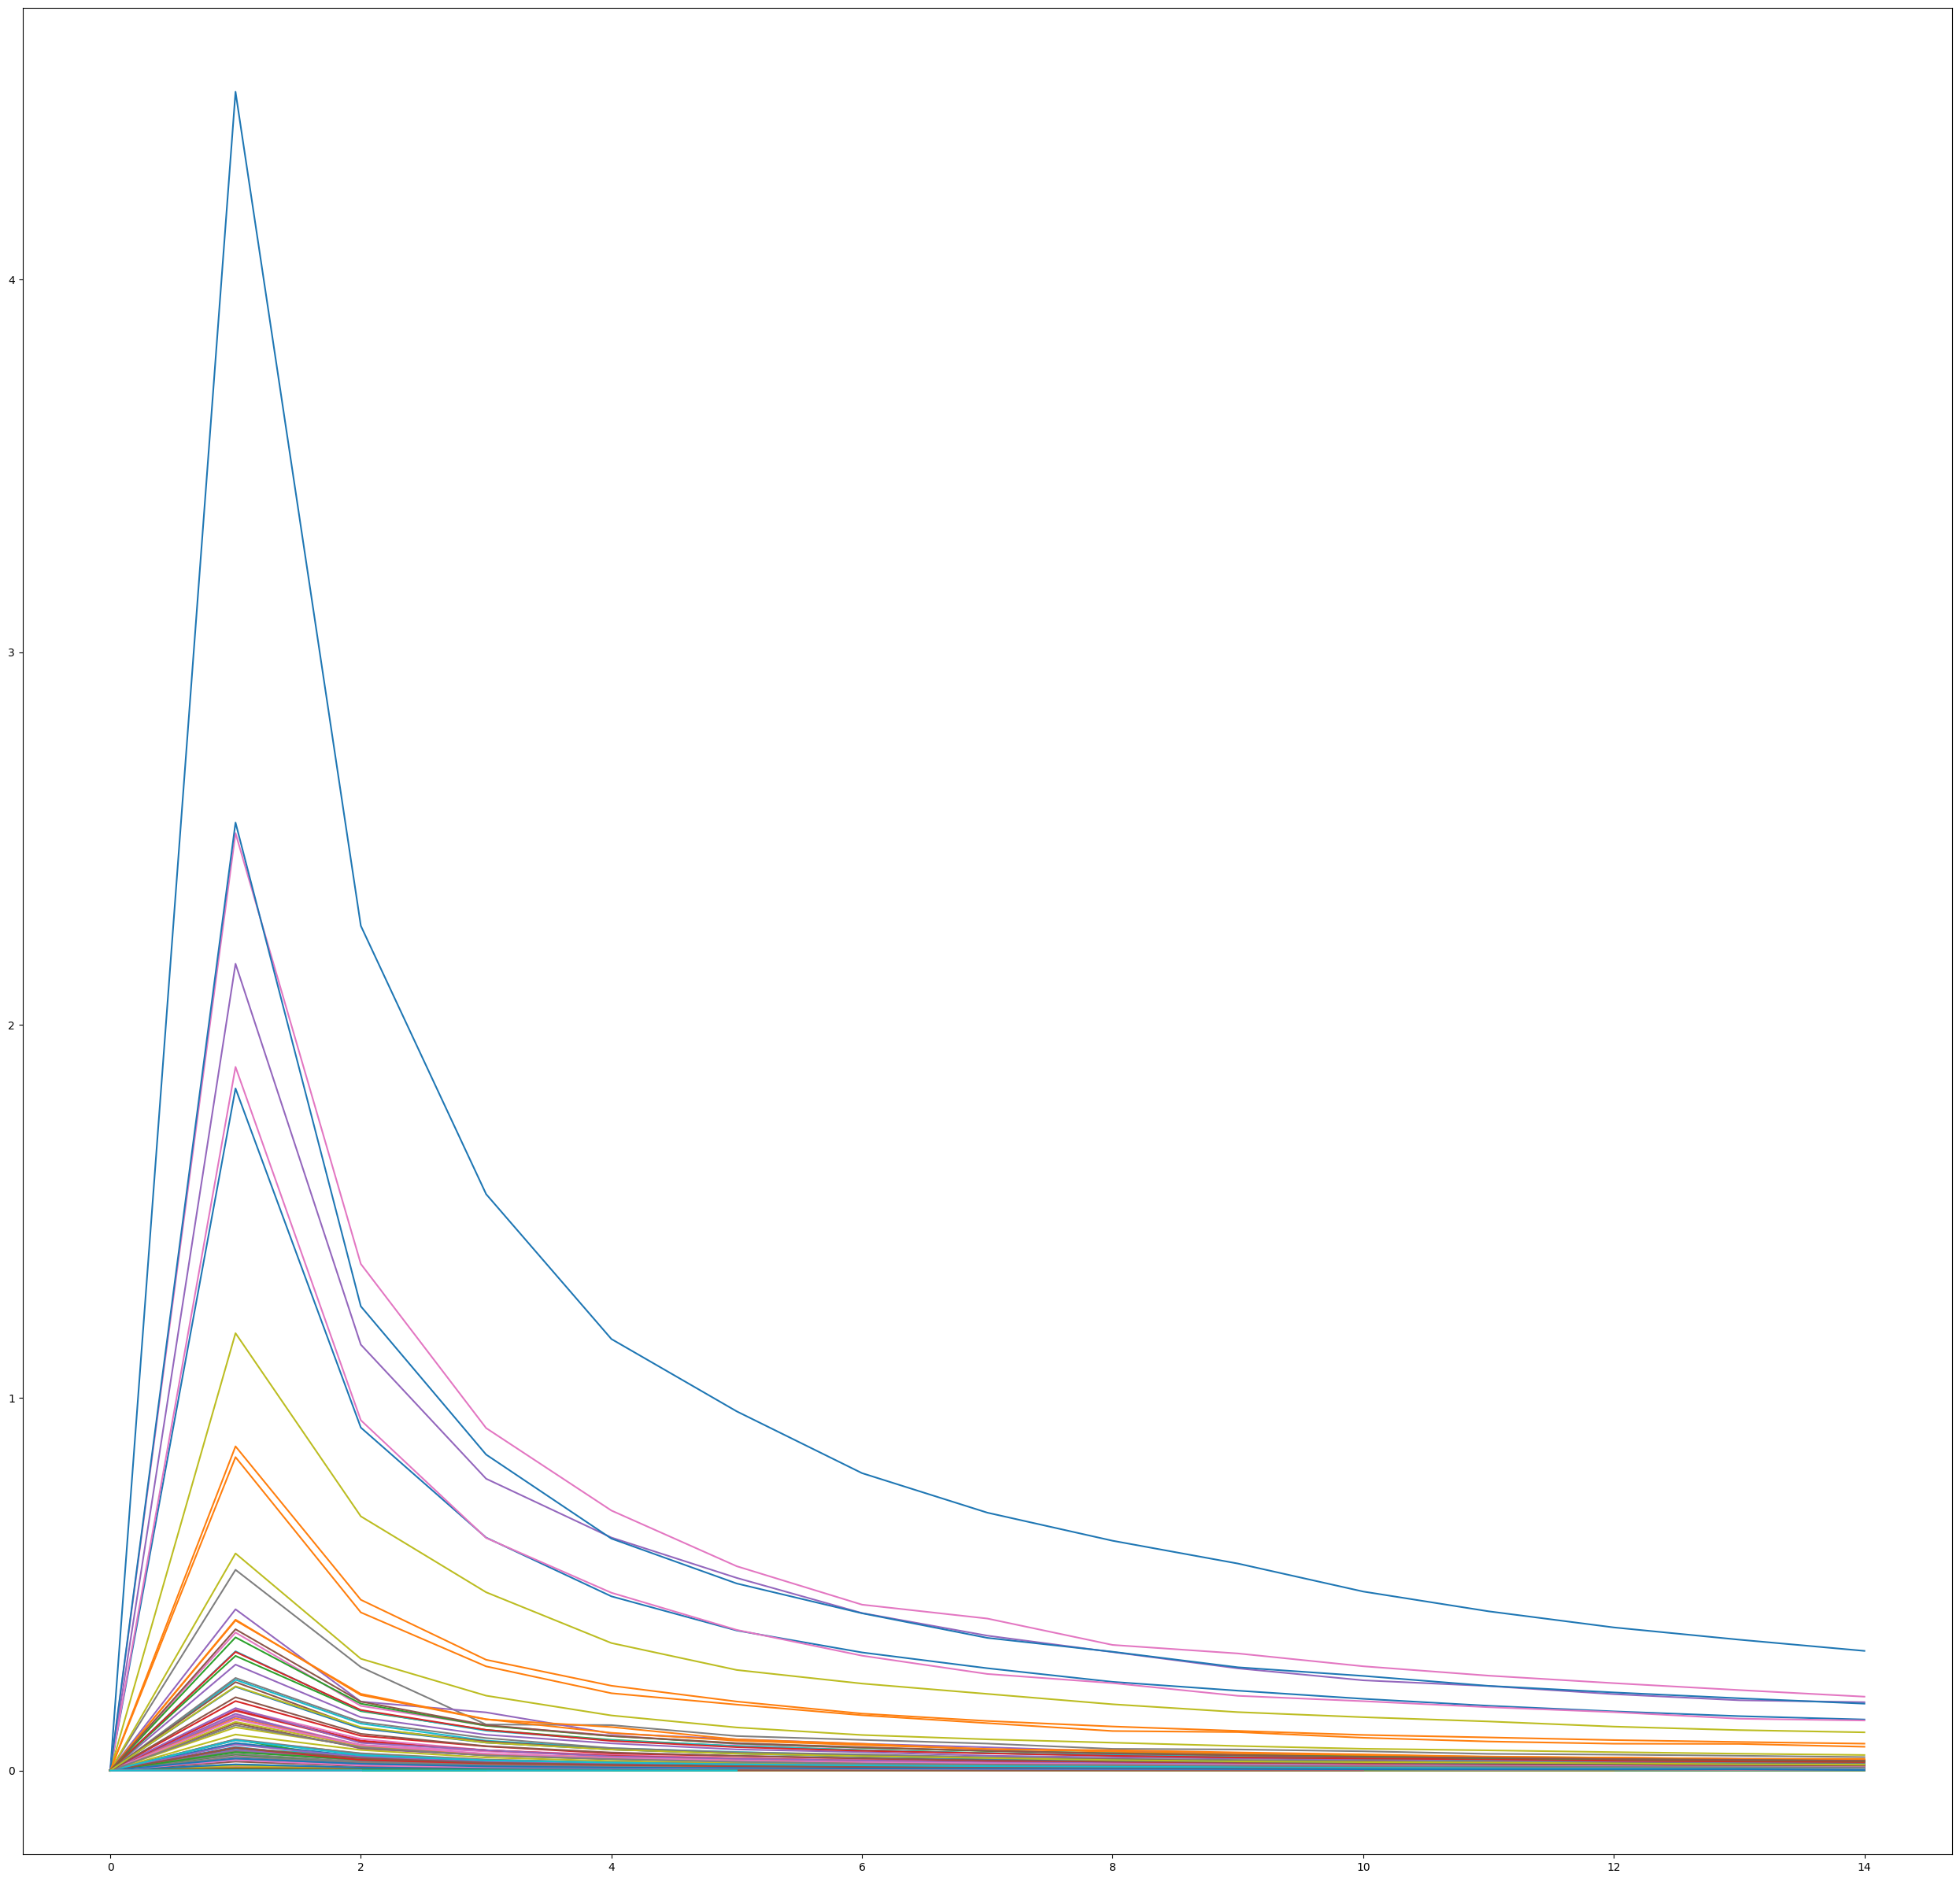

In [ ]:
main()
# getDf()